In [1]:
# Dependencies
import re
import json
import enchant
import datetime
import wordninja
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.dataset.tweets import Tweets 

%matplotlib inline

years = [2017, 2018]
EN_DICT = enchant.Dict("en_US")

# Hashatag analysis

## Whole dataset

In [3]:
# Initialize Tweets class
tweets = Tweets()
# Fill tweets dataframe
tweets.from_json('data/database/tweets.json')

tweets.df.head()

,tweet_date,tweet_id,tweet_text
0,2018-06-30 22:35:06+00:00,1013189209488797697,"#PrideMonth may be ending today, but we will c..."
1,2018-06-30 19:35:07+00:00,1013143915308953606,“This disaster leaves us in extreme poverty......
2,2018-06-30 18:35:07+00:00,1013128815575470081,We want more women on ballots 🗳️ when we go ou...
3,2018-06-30 16:35:09+00:00,1013098625768009728,“The idea that sexism &amp; misogyny in online...
4,2018-06-30 15:05:12+00:00,1013075989885341697,"When women are targeted online, the abuse is m..."


In [4]:
# Compute hashtags occurrences (dict {text : occurrences})
hash_counts = {}
for y in years: 
    hash_counts[y] = tweets.get_hashtag_counts(mask = tweets.df.tweet_date.dt.year == y)

In [5]:
# Plot function for hashtag occurrences
def plot_hashtags_occurrences(counts, year, n_hash_min = 0, n_hash_max = 20):
    # Convert the dictionary in a df, sort it by frequency
    hash_df = pd.DataFrame.from_dict(counts.items())
    hash_df.columns = ["hashtag", "occurrences"]
    hash_df.sort_values(by="occurrences", ascending=False, inplace=True)

    # Plot the barplot with the specified interval of the most frequent hashtags
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    ax.set_title("Hashtag occurrences for {}'s tweets".format(year), fontsize=15)
    hash_df[n_hash_min : n_hash_max].plot(x="hashtag", y="occurrences", kind="bar", ax = ax)

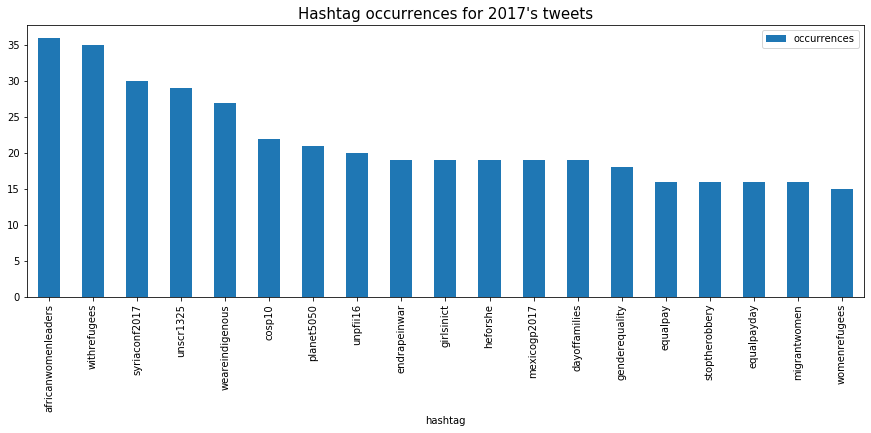

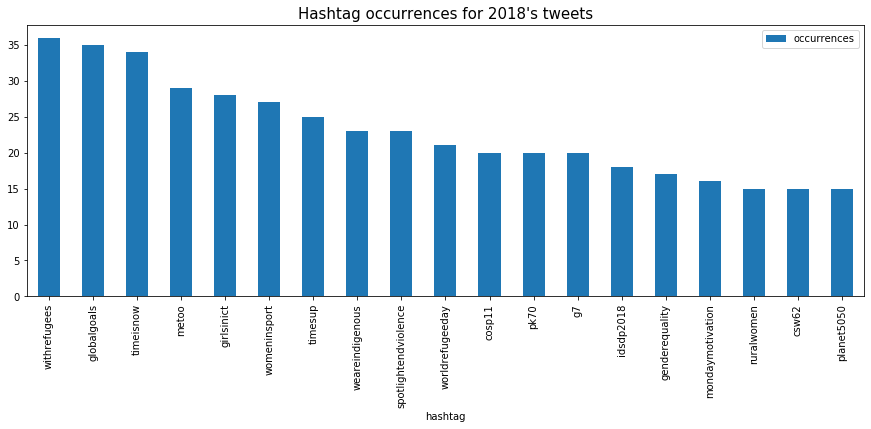

In [6]:
# Show hashtag occurences (without climatechange, too high)
for y in years:
    plot_hashtags_occurrences(hash_counts[y], y, n_hash_min = 1)

### Split hashtags

In [8]:
hashtags = list( set(hash_counts[2017].keys()) | set(hash_counts[2018].keys()) )
splittable_words = {}

for i, hashtag in enumerate(hashtags):
    # define the list of words obtained by splitting the hashtag
    hashtag_splitted = wordninja.split(hashtag)
    # check if the split consists in more than one word
    if (len(hashtag_splitted) > 1) and all([EN_DICT.check(word) for word in hashtag_splitted]):
        # save the word and the suggested splitting
        splittable_words[i] = [ hashtag,
                                ' '.join(hashtag_splitted),
                                hash_counts[2017].get(hashtag, 0),
                                hash_counts[2018].get(hashtag, 0)
                              ]
    else:
        # save the word with a None
        splittable_words[i] = [ hashtag,
                                pd.np.nan,
                                hash_counts[2017].get(hashtag, 0),
                                hash_counts[2018].get(hashtag, 0)
                              ]

splittable_words = pd.DataFrame.from_dict(splittable_words,
                        orient='index',
                        columns=["word", "split", "count_pre", "count_post"])

print(splittable_words.head())
# splittable_words.to_csv('./data/splittable_words.tsv',sep='\t')

                  word                  split  count_pre  count_post
0  worldenvironmentday  world environment day          7           8
1                 mmiw                    NaN          1           0
2            iffla2017                    NaN          1           0
3              jazzday               jazz day          0           7
4          5wordspeech          5 word speech          2           0


In [18]:
len(hashtags)

879

### Select most frequent hashtag to be splitted manually

In [10]:
# Join top_hash pre and post
top_hash = pd.DataFrame.from_dict(hash_counts[2017], orient='index', columns=['occurrences']).join(
           pd.DataFrame.from_dict(hash_counts[2018], orient='index', columns=['occurrences']), 
           how="outer", lsuffix="_pre", rsuffix="_post")

# Remove nans and sum occurrences
top_hash[top_hash.isna()] = 0
top_hash["occurrences"] = top_hash.occurrences_pre + top_hash.occurrences_post
top_hash = pd.DataFrame(top_hash["occurrences"])

# Format (and save) the splitted dataset for the top hashtags
top_splitted = splittable_words.join(top_hash, on="word", how="right")

# Sort the hashtags according to frequency
top_splitted = top_splitted.sort_values(by="occurrences", ascending=False)

# Remove useless columns
top_splitted = top_splitted[["word", "split"]].reset_index(drop=True)

In [11]:
top_splitted[top_splitted.split.isna()].shape

(478, 2)

In [12]:
# Add hashtag symbol to the texts
top_splitted.loc[:,'word'] = top_splitted.word.apply(lambda x: '#' + x )

# Load old splits
old_split = {} # manually curated
with open('data/hashtag_subs.json', 'r') as file:
    old_split = {**old_split, **json.load(file)}
old_split = pd.DataFrame.from_dict(old_split, orient = 'index').reset_index().rename(columns = {'index':'word', 0:'split'})

FileNotFoundError: [Errno 2] No such file or directory: 'data/hashtag_subs.json'

In [10]:
# Function to substitute already-manually-curated hashtags
def sub(row):
    if row.word in list(old_split.word.values):
        row.split = ''.join(old_split.split[old_split.word == row.word].values)
    return row

top_splitted = top_splitted.apply(sub, axis = 1)
top_splitted.head()

,word,split
0,#climatechange,climate change
1,#climate,climate
2,#environment,environment
3,#sustainability,sustainability
4,#sdgs,sustainable development goals


In [13]:
top_splitted[top_splitted.split.isna()].shape

(478, 2)

In [17]:
# Select and save top 600 frequent values
bottom_splitted = top_splitted[400:]
top_splitted = top_splitted[:400]
top_splitted.to_csv("data/top_400_hashtags_raw.tsv", sep='\t')

# Then the hashtags are manually curated and saved in data/hashtags_sub.json'

In [27]:
split = pd.read_csv("data/top_400_hashtags.tsv", index_col=0)
split.head()

,word,split
0,#globalgoals,global goals
1,#withrefugees,with refugees
2,#weareindigenous,we are indigenous
3,#girlsinict,girls in ict
4,#edd18,european development days 2018


In [28]:
split = pd.concat([split, bottom_splitted], ignore_index = True).fillna('')
split.head()

,word,split
0,#globalgoals,global goals
1,#withrefugees,with refugees
2,#weareindigenous,we are indigenous
3,#girlsinict,girls in ict
4,#edd18,european development days 2018


In [29]:
split_dict = {}

def foo(x, d = split_dict):
    d[x.word] = x.split

split.apply(foo, axis = 1)

split_dict

{'#globalgoals': 'global goals',
 '#withrefugees': 'with refugees',
 '#weareindigenous': 'we are indigenous',
 '#girlsinict': 'girls in ict',
 '#edd18': 'european development days 2018',
 '#africanwomenleaders': 'african womens leaders',
 '#planet5050': 'planet 5050',
 '#genderequality': 'gender equality',
 '#timeisnow': 'time is now',
 '#unscr1325': 'united nations security council resolution 1325',
 '#heforshe': 'he for she',
 '#worldrefugeeday': 'world refugee day',
 '#syriaconf2017': 'syria conference 2017',
 '#metoo': 'me too',
 '#dayoffamilies': 'day of families',
 '#equalpayday': 'equal pay day',
 '#endrapeinwar': 'end rape in war',
 '#womeninsport': 'women in sport',
 '#g7': 'g7',
 '#timesup': 'times up',
 '#mondaymotivation': 'monday motivation',
 '#women': 'women ',
 '#crpd': 'convention on the rights of persons with disabilities',
 '#spotlightendviolence': 'spotlight end violence',
 '#equalpay': 'equal pay',
 '#cosp10': 'convention on the rights of persons with disabilities'

In [30]:
# Save dictionay of substitution for the new hashtags
with open('data/hashtag_subs.json', 'w') as fp:
    json.dump(split_dict, fp)

In [30]:
# Save hashtag for Tomaso
for y in hash_counts.keys():
    temp = pd.DataFrame.from_dict(hash_counts[y],orient='index').reset_index().rename(columns={'index':'hashtag', 0:'count'})
    temp.sort_values(by='count', ascending=False).to_csv('data/hashtags_{}.csv'.format(y), index = False)

In [28]:
# Save tweet for Bruno
tweets.df['year'] = tweets.df.tweet_date.dt.year 

tweets.df.to_csv('data/tweet_bruno.csv', index = False)